# 卡尔曼滤波

By Evgenia "Jenny" Nitishinskaya, Dr. Aidan O'Mahony, and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Kalman Filter Beta Estimation Example from [Dr. Aidan O'Mahony's blog.](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/)

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

## 什么是卡尔曼滤波器?

卡尔曼滤波是一种算法，它利用系统随时间的噪声观测来估计系统的参数(其中一些参数是不可观测的)，并预测未来的观测结果。在每个时间步骤中，它进行预测、接受度量，并根据预测和度量的比较方式更新自身。

算法如下:
1. 以系统的数学模型为输入，即
 * 转换矩阵，它告诉我们系统如何从一种状态发展到另一种状态。例如，如果我们正在建模一辆汽车的运动，那么下一个位置和速度的值可以用运动学方程从以前的值计算出来。或者，如果我们有一个相当稳定的系统，我们可以将它的演化建模为随机游走。如果你想了解卡尔曼滤波，注意这个矩阵通常被称为$A$。
 * 观测矩阵，它告诉我们，给定预测的下一个状态，我们应该期望的下一个测量值。如果我们要测量汽车的位置，我们只需提取存储在状态中的位置值。对于更复杂的示例，考虑对数据估计一个线性回归模型。那么我们的状态就是模型的系数，我们可以从线性方程中预测下一个测量值。这里记作$H$。
 * 影响状态转换但不属于测量范围的任何控制因素。例如，如果我们的车在下降，重力就是一个控制因素。如果噪声的均值不为0，则将其平移，并将偏移量放入控制因子中。控制因子用矩阵$B$和时变控制向量$u_t$表示，得到偏移量$Bu_t$。
 * 转化噪声(即系统演化中的噪声)和测量噪声的协方差矩阵，分别为$Q$和$R$。
2. 将系统状态的初始估计值和估计值的误差$\mu_0$和$\sigma_0$作为输入。
3. 在每一个时间步骤:
 * 使用转换矩阵估计系统$x_t$的当前状态
 * 输入新的测量值$z_t$
 * 利用给定状态下的测量值的条件概率，考虑测量值和状态估计的不确定性，更新系统的估计当前状态$x_t$和估计值$P_t$的协方差矩阵

[这张图](https://upload.wikimedia.org/wikipedia/commons/a/a5/Basic_concept_of_Kalman_filtering.svg)演示了算法所遵循的过程。

对于算法来说，跟踪估计的协方差是非常重要的。通过这种方式，当我们请求它时，它可以给我们一个比简单的点值更微妙的结果，并且它可以使用它的置信度来决定在更新过程中受新度量的影响程度。对状态的估计越肯定，对与状态不一致的测量就越怀疑。

默认情况下，假设误差是正态分布的，这个假设允许算法计算精确的置信区间。但是，它可以用于非正态误差。

In [1]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d
import yfinance as yf

# 小例子:下落的球

假设我们有一个正在下落的球，我们用摄像机跟踪它的运动。球的状态由它的位置和速度组成。我们知道有关系 $x_t = x_{t-1} + v_{t-1}\tau - \frac{1}{2} g \tau^2$, 其中$\tau$为$t-1$与$t$之间经过的时间(以秒为单位)，$g$为重力加速度。同时，我们的相机可以告诉我们每一秒球的位置，但我们从制造商那里知道，相机的精度，转换成球的位置，意味着3米左右的位置估计的方差。

为了使用卡尔曼滤波，我们需要给它转换和观测矩阵，过渡和观测协方差矩阵，以及初始状态。系统的状态是(位置，速度)，所以它遵循转换矩阵
$$ \left( \begin{array}{cc}
1 & \tau \\
0 & 1 \end{array} \right) $$

使用偏移量$(-\tau^2 \cdot g/2， -\tau\cdot g)$。观察矩阵只是提取位置坐标(1,0)，因为我们在测量位置。我们知道观测方差是1，而过渡协方差是0，因为我们将按照指定模型的方式模拟数据。对于初始状态，让我们为我们的模型提供一些虚假的东西，比如(30,10)，然后看看我们的系统是如何发展的。

In [2]:
tau = 0.1

# Set up the filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # position is 1-dimensional, (x,v) is 2-dimensional
                  initial_state_mean=[30,10],
                  initial_state_covariance=np.eye(2),
                  transition_matrices=[[1,tau], [0,1]],
                  observation_matrices=[[1,0]],
                  observation_covariance=3,
                  transition_covariance=np.zeros((2,2)),
                  transition_offsets=[-4.9*tau**2, -9.8*tau])

In [3]:
# Create a simulation of a ball falling for 40 units of time (each of length tau)
times = np.arange(40)
actual = -4.9*tau**2*times**2

# Simulate the noisy camera data
sim = actual + 3*np.random.randn(40)

# Run filter on camera data
state_means, state_covs = kf.filter(sim)

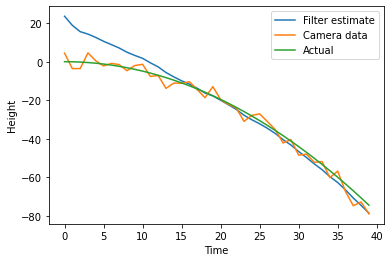

In [4]:
plt.plot(times, state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Filter estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

在每个时间点上，我们在考虑了最近的测量<i>之后</i>绘制状态估计，这就是为什么我们在时间0时不在位置30。过滤器对测量值的关注使它能够纠正我们给它的初始虚假状态。然后，通过权衡它的模型和物理定律的知识与新的测量，它能够过滤掉相机数据中的大部分噪声。同时，对估计值的信心随着时间的增加而增加，如下图所示:

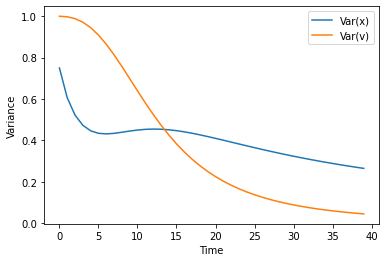

In [5]:
# Plot variances of x and v, extracting the appropriate values from the covariance matrix
plt.plot(times, state_covs[:,0,0])
plt.plot(times, state_covs[:,1,1])
plt.legend(['Var(x)', 'Var(v)'])
plt.ylabel('Variance')
plt.xlabel('Time');

卡尔曼滤波还可以进行<i>平滑</i>处理，即一次处理所有的输入数据，然后对每个周期后的系统状态进行最佳猜测。也就是说，它不提供在线的、运行的估计，而是使用所有的数据来估计历史状态，如果我们只想在收集所有数据之后使用这些数据，那么这是非常有用的。

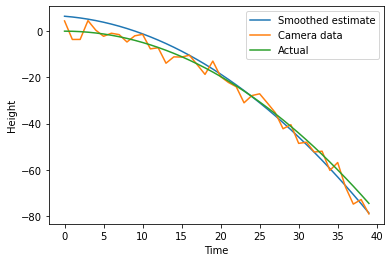

In [6]:
# Use smoothing to estimate what the state of the system has been
smoothed_state_means, _ = kf.smooth(sim)

# Plot results
plt.plot(times, smoothed_state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Smoothed estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

# 例如:移动平均

由于卡尔曼滤波在每一步都更新估计，而且倾向于把最近的观测结果看得比旧的更重要，因此一个特别有用的应用是估计数据的滚动参数。在使用卡尔曼滤波器时，我们不需要指定窗口长度。这对于计算移动平均很有用，如果这是我们感兴趣的，或者对于平滑其他量的估计也很有用。例如，如果我们已经计算了移动的夏普比率，我们可以使用卡尔曼滤波器平滑它。

下面，我们将使用卡尔曼滤波和n天移动平均线来估计数据集的滚动平均值。我们希望平均值能很好地描述我们的观察结果，所以当我们添加一个观察结果时，它不会发生太大的变化;因此，我们假设它是一个带有小误差项的随机游动。均值是模型对分布均值的猜测，因此我们对下一个值的预测就等于我们对均值的估计。由于缺乏更好的估计值，我们假定观测值的方差为1。我们最初对平均值的猜测是0，但过滤器很快意识到这是不正确的，并进行了调整。

[*********************100%***********************]  1 of 1 completed


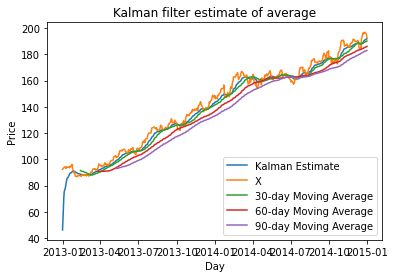

In [7]:
# Load pricing data for a security
start = '2013-01-01'
end = '2015-01-01'
x = yf.download('LMT', start,end)['Close']

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

# Compute the rolling mean with various lookback windows
mean30 = x.rolling(window = 30).mean()
mean60 = x.rolling(window = 60).mean()
mean90 = x.rolling(window = 90).mean()

# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.plot(mean30)
plt.plot(mean60)
plt.plot(mean90)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

这有点难看出来，所以我们要画出这个图的一部分。

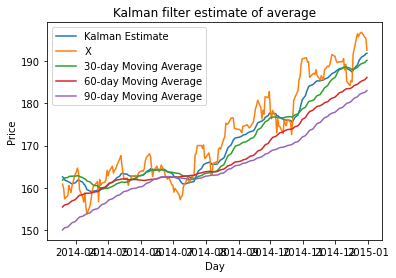

In [8]:
plt.plot(state_means[-200:])
plt.plot(x[-200:])
plt.plot(mean30[-200:])
plt.plot(mean60[-200:])
plt.plot(mean90[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price');

卡尔曼滤波的优点是我们不需要选择窗口长度，因此我们运行过拟合的风险更小。我们确实会对过滤器的一些初始化参数进行过度拟合，但是这些参数更容易客观地定义。没有免费的午餐，我们也不能消除过度拟合，但卡尔曼滤波比移动平均线更严格，而且总体上更好。

# 例如:线性回归

让我们尝试使用卡尔曼滤波器来查找数据集的线性回归线。我们将把股票价格与标准普尔500指数进行比较，因此结果将是股票的某种滚动alpha和beta，其中$\alpha$和$\beta$是线性回归方程的参数
$$ y_t \approx \alpha + \beta x_t $$

下面，我们使用颜色来表示数据点$(x_t, y_t)$对应的日期。

In [9]:
# Load pricing data
start = '2012-01-01'
end = '2015-01-01'
y = yf.download('AMZN', start,end)['Close']
x = yf.download('SPY', start,end)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


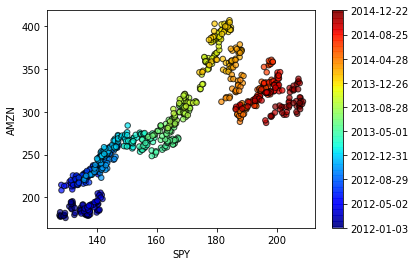

In [10]:
# Plot data and use colormap to indicate the date each point corresponds to
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('SPY')
plt.ylabel('AMZN');

我们算出卡尔曼滤波器的输入。我们将系统的状态定义为观察结果所遵循的直线，参数为$\alpha$和$\beta$。我们对这些参数的初始猜测是(0,0)，所有参数的协方差矩阵(它描述了我们的猜测的误差)都是(0,0)。在滚动平均值的例子中，我们假设我们的参数遵循一个随机游走(转换矩阵是单位矩阵)，带有一个小的误差项(转换协方差是单位矩阵的一个小的倍数)。

为了从我们的系统状态得到一个观测值，我们将状态$(\beta， \alpha)$与$(x_i, 1)$点乘，得到$\beta x_i + \alpha \approx y_i$，所以我们的观测矩阵就是一列1粘在$x$上。我们假设观测值$y$的方差是2。现在，我们准备使用我们对$y$的观察来演进我们对参数$\beta$和 $\alpha$的估计。

In [11]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

In [12]:
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values)

下面我们将绘制出$\alpha$和$\beta$随时间变化的平均值(即我们的最佳估计值)。

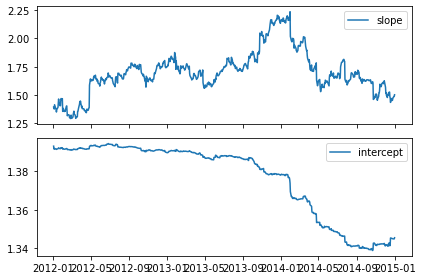

In [13]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout();

注意参数在长时间内的波动。如果我们的交易算法是基于此，比如涉及到贝塔对冲，重要的是要有最好的和最新的贝塔估计。为了可视化系统是如何随时间演化的，我们在下面绘制了每个第五个状态(线性模型)。为了进行比较，在黑色中，我们使用全数据集上的普通最小二乘回归来返回这条线，这是非常不同的。

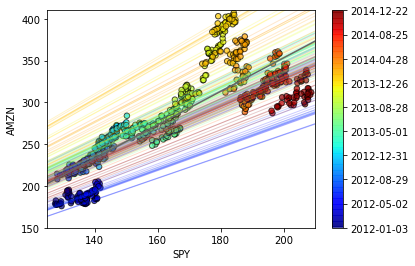

In [14]:
# Plot data points using colormap
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x.min()-5, x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([125, 210, 150, 410])

# Label axes
plt.xlabel('SPY')
plt.ylabel('AMZN');

请注意，虽然所有的状态估计都考虑了所有以前的观察结果，但它们更适合最近的数据，而不是更老的数据。这允许过滤器适应数据随时间的结构变化。

现在，大多数时候我们更关心收益的相关性而不是价格的相关性，所以让我们快速地对收益数据使用相同的线性回归结构:

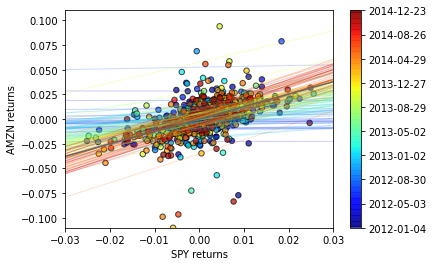

In [15]:
# Get returns from pricing data
x_r = x.pct_change()[1:]
y_r = y.pct_change()[1:]

# Run Kalman filter on returns data
delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[x_r], [np.ones(len(x_r))]]).T, axis=1)
kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)
state_means_r, _ = kf_r.filter(y_r.values)

# Plot data points using colormap
colors_r = np.linspace(0.1, 1, len(x_r))
sc = plt.scatter(x_r, y_r, s=30, c=colors_r, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x_r[::len(x_r)//9].index])

# Plot every fifth line
step = 5
xi = np.linspace(x_r.min()-4, x_r.max()+4, 2)
colors_l = np.linspace(0.1, 1, len(state_means_r[::step]))
for i, beta in enumerate(state_means_r[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))

# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_r, y_r, 1))(xi), '0.4')

# Adjust axes for visibility
plt.axis([-0.03,0.03,-0.11, 0.11])

# Label axes
plt.xlabel('SPY returns')
plt.ylabel('AMZN returns');

虽然原始数据在这里更加混乱，但是我们可以看到回归线在演进，甚至在OLS回归线上摇摆。

# 扩展

我们也可以使用卡尔曼滤波器来模拟非线性转换和观测函数。为此目的，存在扩展和无气味的卡尔曼过滤器，后者包括在“pykalman”中。这些模型甚至可以模拟噪声不是附加的情况(例如，噪声与测量的大小成比例)。我们还可以指定非高斯误差，这在金融数据中很有用，因为金融数据往往具有重尾分布。

还有一些算法用于从初始数据集推断某些输入参数，如协方差矩阵和初始状态。这可以使用`pykalman.em()`方法来完成。